# Imports

In [238]:
import pandas as pd
import glob
import os
import numpy as np
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
from tqdm.auto import tqdm
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Functions

In [239]:
def check_missing_players(player_list, player_data):
    missing_players = []
    for game in player_list:
        for team in game:
            for player in team:
                if player.lower() not in player_data:
                    missing_players.append(player)
    return missing_players


def get_names(df, start, stop):
    player_list = []
    drop_list = df.iloc[:, start:stop:3].columns.tolist()
    name_df = df.drop(drop_list, axis=1, inplace=False)
    name_df = name_df.iloc[:, start:stop-len(drop_list)]
    for i in range(len(name_df)):
        players = name_df.iloc[i].tolist()
        players_sorted = [players[j] for j in range(0, len(players), 2)]
        players_sorted.sort(key=lambda x: players[players.index(x) + 1])
        player_list.append(players_sorted)
    return player_list


def list_stacker(pitchers, players):
    for i in range(len(pitchers)):
        players[i].insert(0, pitchers[i])
    return players


def get_game_data(paths):
    all_data = []
    for i in range(len(paths)):
        df = pd.read_csv(paths[i], header=None)
        visiting_players = get_names(df, 105, 132)
        home_players = get_names(df, 132, 159)
        home_pitchers = df.iloc[:, 104].tolist()
        visiting_pitchers = df.iloc[:, 102].tolist()
        visiting_players = list_stacker(visiting_pitchers, visiting_players)
        home_players = list_stacker(home_pitchers, home_players)
        visiting_scores = df.iloc[:, 9].tolist()
        home_scores = df.iloc[:, 10].tolist()
        all_data.extend(list(zip(visiting_players, home_players, visiting_scores, home_scores)))
    return all_data


def get_player_data(paths):
    le = LabelEncoder()
    player_dfs = []
    for path in paths:
        df = pd.read_csv(path)
        df['Team'] = le.fit_transform(df['Team'])
        if 'Pos' in df.columns:
            df['Pos'] = le.fit_transform(df['Pos'])
        if 'Batters' not in path:
            df['ExtraCol1'] = 0
            df['ExtraCol2'] = 0
            df['ExtraCol3'] = 0
        df.columns = ['Player'] + list(range(len(df.columns) - 1))
        df['Player'] = df['Player'].str.lower()
        player_dfs.append(df)
    combined_player = pd.concat(player_dfs)
    combined_player = combined_player.groupby('Player', as_index=False).mean()
    final_player = combined_player.set_index('Player').T.to_dict('list')
    return final_player


def get_example(game, player_data):
    visiting_players = game[0]
    home_players = game[1]
    visiting_vector = [player_data[player.lower()] for player in visiting_players]
    home_vector = [player_data[player.lower()] for player in home_players]
    stacked_vector = [item for sublist in visiting_vector + home_vector for item in sublist]
    if game[2] > game[3]:
        label = 0 # might need to flip
    else:
        label = 1
    return stacked_vector, label


def generate_vectors_and_labels(game_data, player_data):
    vectors, labels = [], []
    for game in tqdm(game_data):
        try:
            vector, label = get_example(game, player_data)
            if np.isnan(vector).any() or np.isnan(label):
                continue
            vectors.append(vector)
            labels.append(label)
        except:
            continue
    return pd.DataFrame(np.array(vectors)), pd.DataFrame(np.array(labels))


def simulate_betting_season(bets, df, wallet_balance=1000.0):

    wallet_balance_history = [wallet_balance]  # Start with the initial wallet balance
    for bet in bets:
        bet_amount, bet_team, bet_date = bet
        row = df[(df['date'] == bet_date) & ((df['home_team'] == bet_team) | (df['visiting_team'] == bet_team))]
        if not row.empty and not row.isnull().values.any():
            if row['winner'].values[0]==1:
                winner = row['home_team'].values[0]
                if winner == bet_team:
                    if row['home_open'].values[0] > 0:
                        wallet_balance += bet_amount * (row['home_open'].values[0] / 100.0)
                    else:
                        wallet_balance += bet_amount * (100.0 / abs(row['home_open'].values[0]))
                else:
                    wallet_balance -= bet_amount
            else:
                winner = row['visiting_team'].values[0]
                if winner == bet_team:
                    if row['visiting_open'].values[0] > 0:
                        wallet_balance += bet_amount * (row['visiting_open'].values[0] / 100.0)
                    else:
                        wallet_balance += bet_amount * (100.0 / abs(row['visiting_open'].values[0]))
                else:
                    wallet_balance -= bet_amount
            wallet_balance_history.append(wallet_balance)
        else:
            print(f"No betting data for date: {bet_date}")
    return wallet_balance, wallet_balance_history


def get_player_vector(players, player_data):
    return [player_data[player.lower()] for player in players]


def predict_game_outcome(player_list, player_data, model, augment=False, base_bet=100, scaler=1):
    results, bets, skipped = [], [], []
    for i in range(len(player_list)):
        try:
            visiting_players = player_list.iloc[i][0][0]
            home_players = player_list.iloc[i][0][1]
            visiting_vector = get_player_vector(visiting_players, player_data)
            home_vector = get_player_vector(home_players, player_data)
            game_vector = [item for sublist in visiting_vector + home_vector for item in sublist]  # Flatten the vectors
            game_vector = torch.tensor([game_vector], dtype=torch.float)
            model.eval()
            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results.append(pred)
            bets.append(base_bet * prob * scaler if augment else base_bet)
        except:
            skipped.append(i)
    return results, bets, skipped


def generate_bets(results, bets, df, skipped):
    final_bets = []
    for i, (result, (_, row)) in enumerate(zip(results, df.iterrows())):
        if i in skipped:
            continue
        if result == 1:
            bet_team = row['home_team']
        else:
            bet_team = row['visiting_team']
        bet_date = row['date']
        final_bets.append((bets[i], bet_team, bet_date))
    return final_bets

# Data

In [240]:
def load_data(game_path, player_path, train_years, test_year):
    game_csvs_train = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if str(test_year) not in path and any(str(year) in path for year in train_years)]
    game_csvs_test = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if str(test_year) in path]

    player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if str(test_year) not in path and any(str(year) in path for year in train_years)]
    player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if str(test_year) in path]

    train_game_data = [game for game in get_game_data(game_csvs_train) if game[2] != game[3]]
    test_game_data = [game for game in get_game_data(game_csvs_test) if game[2] != game[3]]

    train_player_data = get_player_data(player_csvs_train)
    test_player_data = get_player_data(player_csvs_test)

    X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
    X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)
    print(game_csvs_train)
    print(player_csvs_train)
    print(game_csvs_test)
    print(player_csvs_test)
    return X_train, y_train, X_test, y_test, train_game_data, test_game_data, train_player_data, test_player_data

# load data
game_path = './game_data/'
player_path = './player_data/'

test_year = 2020
train_years = range(2010, test_year) #train years from 2010 to test year -1 for some reason range reduces the year by 1.

X_train, y_train, X_test, y_test, train_game_data, test_game_data, train_player_data, test_player_data = load_data(game_path, player_path, train_years, test_year)

player_path = './player_data/'
paths = [path.replace('\\', '/') for path in glob(player_path + '*.csv')]
for path in paths:
    df = pd.read_csv(path)
    view_data(df)

xlsx_path = './betting_odds/'
txt_path = './alldata/gamelogs/'
glfields_path = './alldata/gamelogs/glfields.txt'
paths = [path for path in glob(xlsx_path + '*.xlsx')]
paths_txt = [f'{txt_path}gl{test_year}.txt']
schedule_paths = [f'./alldata/schedules/{year}schedule.csv' for year in range(2010, 2024)]

100%|██████████| 898/898 [00:00<00:00, 33031.52it/s]

['./game_data/gl2010.txt', './game_data/gl2011.txt', './game_data/gl2012.txt', './game_data/gl2013.txt', './game_data/gl2014.txt', './game_data/gl2015.txt', './game_data/gl2016.txt', './game_data/gl2017.txt', './game_data/gl2018.txt', './game_data/gl2019.txt']
['./player_data/mlb-player-stats-Batters_2015.csv', './player_data/mlb-player-stats-Batters_2016.csv', './player_data/mlb-player-stats-Batters_2017.csv', './player_data/mlb-player-stats-Batters_2018.csv', './player_data/mlb-player-stats-Batters_2019.csv', './player_data/mlb-player-stats-P_2015.csv', './player_data/mlb-player-stats-P_2016.csv', './player_data/mlb-player-stats-P_2017.csv', './player_data/mlb-player-stats-P_2018.csv', './player_data/mlb-player-stats-P_2019.csv']
['./game_data/gl2020.txt']
['./player_data/mlb-player-stats-Batters_2020.csv', './player_data/mlb-player-stats-P_2020.csv']
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN 

In [241]:
print(paths_txt)

['./alldata/gamelogs/gl2020.txt']


In [242]:


# # load data
# game_path = './game_data/'
# player_path = './player_data/'

# game_csvs_train = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2019' not in path and '2020' not in path and '2021' not in path and '2022' not in path and '2023' not in path]
# game_csvs_test = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2019' in path]

# player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2019' not in path and '2020' not in path and '2021' not in path and '2022' not in path and '2023' not in path]
# player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2019' in path]

# train_game_data = [game for game in get_game_data(game_csvs_train) if game[2] != game[3]]
# test_game_data = [game for game in get_game_data(game_csvs_test) if game[2] != game[3]]

# train_player_data = get_player_data(player_csvs_train)
# test_player_data = get_player_data(player_csvs_test)

# X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
# X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)

In [243]:
xlsx_dataframes = []
for i, path in enumerate(paths):
    temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
    temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
    year = path[-9:-5]  # extract year from file name
    if 'Date' in temp_df.columns:
        temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
    xlsx_dataframes.append(temp_df)

try:
    xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
except pd.errors.InvalidIndexError:
    print('Error: Reindexing only valid with uniquely valued Index objects')

with open(glfields_path, 'r') as file:
    glfields_data = file.read()

xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

home_teams_df.rename(columns={'Date': 'date', 'Team': 'home_team', 'Open': 'home_open'}, inplace=True)
visiting_teams_df.rename(columns={'Date': 'date', 'Team': 'visiting_team', 'Open': 'visiting_open'}, inplace=True)

# Merge on 'date'
xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]
print(xlsx_dataframes)
headers = [
    "date",
    "number_of_game",
    "day_of_week",
    "visiting_team",
    "visiting_team_league",
    "visiting_team_game_number",
    "home_team",
    "home_team_league",
    "home_team_game_number",
    "visiting_team_score",
    "home_team_score",
    "length_of_game_in_outs",
    "day_night_indicator",
    "completion_information",
    "forfeit_information",
    "protest_information",
    "park_id",
    "attendance",
    "time_of_game_in_minutes",
    "visiting_team_line_scores",
    "home_team_line_scores",
    "visiting_team_at_bats",
    "visiting_team_hits",
    "visiting_team_doubles",
    "visiting_team_triples",
    "visiting_team_homeruns",
    "visiting_team_RBI",
    "visiting_team_sacrifice_hits",
    "visiting_team_sacrifice_flies",
    "visiting_team_hit_by_pitch",
    "visiting_team_walks",
    "visiting_team_intentional_walks",
    "visiting_team_strikeouts",
    "visiting_team_stolen_bases",
    "visiting_team_caught_stealing",
    "visiting_team_grounded_into_double_plays",
    "visiting_team_awarded_first_on_catchers_interference",
    "visiting_team_left_on_base",
    "visiting_team_pitchers_used",
    "visiting_team_individual_earned_runs",
    "visiting_team_team_earned_runs",
    "visiting_team_wild_pitches",
    "visiting_team_balks",
    "visiting_team_putouts",
    "visiting_team_assists",
    "visiting_team_errors",
    "visiting_team_passed_balls",
    "visiting_team_double_plays",
    "visiting_team_triple_plays",
    "home_team_at_bats",
    "home_team_hits",
    "home_team_doubles",
    "home_team_triples",
    "home_team_homeruns",
    "home_team_RBI",
    "home_team_sacrifice_hits",
    "home_team_sacrifice_flies",
    "home_team_hit_by_pitch",
    "home_team_walks",
    "home_team_intentional_walks",
    "home_team_strikeouts",
    "home_team_stolen_bases",
    "home_team_caught_stealing",
    "home_team_grounded_into_double_plays",
    "home_team_awarded_first_on_catchers_interference",
    "home_team_left_on_base",
    "home_team_pitchers_used",
    "home_team_individual_earned_runs",
    "home_team_team_earned_runs",
    "home_team_wild_pitches",
    "home_team_balks",
    "home_team_putouts",
    "home_team_assists",
    "home_team_errors",
    "home_team_passed_balls",
    "home_team_double_plays",
    "home_team_triple_plays",
    "home_plate_umpire_id",
    "home_plate_umpire_name",
    "first_base_umpire_id",
    "first_base_umpire_name",
    "second_base_umpire_id",
    "second_base_umpire_name",
    "third_base_umpire_id",
    "third_base_umpire_name",
    "left_field_umpire_id",
    "left_field_umpire_name",
    "right_field_umpire_id",
    "right_field_umpire_name",
    "visiting_team_manager_id",
    "visiting_team_manager_name",
    "home_team_manager_id",
    "home_team_manager_name",
    "winning_pitcher_id",
    "winning_pitcher_name",
    "losing_pitcher_id",
    "losing_pitcher_name",
    "saving_pitcher_id",
    "saving_pitcher_name",
    "game_winning_rbi_batter_id",
    "game_winning_rbi_batter_name",
    "visiting_starting_pitcher_id",
    "visiting_starting_pitcher_name",
    "home_starting_pitcher_id",
    "home_starting_pitcher_name",
]
for i in range(1, 10):
    headers.extend([
        f"visiting_starting_player_{i}_id",
        f"visiting_starting_player_{i}_name",
        f"visiting_starting_player_{i}_defensive_position"
    ])

for i in range(1, 10):
    headers.extend([
        f"home_starting_player_{i}_id",
        f"home_starting_player_{i}_name",
        f"home_starting_player_{i}_defensive_position"
    ])

headers.extend(["additional_information", "acquisition_information"])

txt_dataframes = []
for path_txt in paths_txt:
    df = pd.read_csv(path_txt, delimiter = ",", quotechar='"', quoting=1, header = None)
    df.columns = headers
    txt_dataframes.append(df)
    # view_data(df)
# txt_dataframes = txt_dataframes.replace({',': '', '\"': ''}, regex=True)
# If you want to view the file in Excel, uncomment the following line
# os.startfile(xlsx_files[0])
# Concatenate all dataframes in txt_dataframes into a single dataframe
txt_dataframes_concat = pd.concat(txt_dataframes)

# Determine the winning team for each game and add it as a new column 'winner'
txt_dataframes_concat['winner'] = txt_dataframes_concat.apply(lambda row: 1 if row["home_team_score"] > row["visiting_team_score"] else 2 if row["home_team_score"] == row["visiting_team_score"] else 0, axis=1)

# Drop all columns except for the visiting and home pitchers, starting players, home_team, visiting_team, date, coach, and winner
# txt_dataframes_concat = txt_dataframes_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
#                                               'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
#                                               'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
#                                               'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
#                                               'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
#                                               'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
#                                               'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
#                                               'home_team_score','visiting_team_score','winner']]
txt_dataframes_concat = txt_dataframes_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
                                              'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
                                              'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
                                              'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
                                              'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
                                              'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
                                              'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
                                              'winner']]

xlsx_dataframes['date'] = xlsx_dataframes['date'].astype(int)
txt_dataframes_concat['date'] = txt_dataframes_concat['date']
# Now perform the merge operation
merged_dataframes = pd.merge(xlsx_dataframes, txt_dataframes_concat, on=['date', 'home_team', 'visiting_team'])
merged_dataframes_full = pd.merge(txt_dataframes_concat,xlsx_dataframes, on=['date', 'home_team', 'visiting_team'],how="left")

# Now, merged_data should only contain bets on actual games played

player_list_concat = pd.concat(txt_dataframes)
player_list_concat = player_list_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
                                              'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
                                              'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
                                              'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
                                              'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
                                              'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
                                              'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
                                              'home_team_score','visiting_team_score',
                                              'home_starting_player_1_defensive_position', 'home_starting_player_2_defensive_position', 
                                              'home_starting_player_3_defensive_position', 'home_starting_player_4_defensive_position', 
                                              'home_starting_player_5_defensive_position', 'home_starting_player_6_defensive_position', 
                                              'home_starting_player_7_defensive_position', 'home_starting_player_8_defensive_position', 
                                              'home_starting_player_9_defensive_position', 'visiting_starting_player_1_defensive_position', 
                                              'visiting_starting_player_2_defensive_position', 'visiting_starting_player_3_defensive_position', 
                                              'visiting_starting_player_4_defensive_position', 'visiting_starting_player_5_defensive_position', 
                                              'visiting_starting_player_6_defensive_position', 'visiting_starting_player_7_defensive_position', 
                                              'visiting_starting_player_8_defensive_position', 'visiting_starting_player_9_defensive_position']]

player_list_concat['lineup'] = player_list_concat.apply(lambda row: [
    (
        (row['visiting_starting_pitcher_name'],) +
        tuple(row[f'visiting_starting_player_{i}_name'] for i in sorted(range(1, 10), key=lambda i: row[f'visiting_starting_player_{i}_defensive_position']))
    ),
    (
        (row['home_starting_pitcher_name'],) +
        tuple(row[f'home_starting_player_{i}_name'] for i in sorted(range(1, 10), key=lambda i: row[f'home_starting_player_{i}_defensive_position']))
    ),
    # row['visiting_team_score'],
    # row['home_team_score']
], axis=1).tolist()

merged_player_dataframe = pd.merge(xlsx_dataframes, player_list_concat, on=['date', 'home_team', 'visiting_team'])

           date home_team visiting_team  home_open  visiting_open
0      20100404       BOS           NYY       -114           -106
1      20100405       WAS           PHI        170           -200
2      20100405       NYM           MIA       -115           -105
3      20100405       CIN           STL        135           -155
4      20100405       PIT           LOS        135           -155
...         ...       ...           ...        ...            ...
28001  20211027       HOU           ATL       -115           -105
28002  20211029       ATL           HOU       -115           -105
28003  20211030       ATL           HOU       -115           -105
28004  20211031       ATL           HOU       -105           -115
28005  20211102       HOU           ATL       -120            100

[28006 rows x 5 columns]


In [244]:
# xlsx_dataframes.to_csv('output.csv', index=False)

In [245]:
# print(merged_player_dataframe['lineup'])

# NN

In [246]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)
model

neural_net(
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.15, inplace=False)
  (input_layer): Linear(in_features=440, out_features=880, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=880, out_features=880, bias=True)
  )
  (output_layer): Linear(in_features=880, out_features=2, bias=True)
)

In [247]:
train_dataset = vector_dataset(X_train, y_train)
test_dataset = vector_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [248]:
patience = 15
best_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'  # File path for saving the best model

for epoch in range(50):  # number of epochs
    model.train()
    train_losses = []
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    print(f'Training Loss: {avg_train_loss}')

    model.eval()
    valid_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            valid_losses.append(loss.item())

    avg_valid_loss = np.mean(valid_losses)
    print(f'Validation Loss: {avg_valid_loss}')

    # Save the model at each epoch
    epoch_model_path = f'model_epoch_{epoch + 1}.pth'
    torch.save(model.state_dict(), epoch_model_path)

    # Update the best model if validation loss improves
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Evaluate the best model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Epoch 1: 100%|██████████| 168/168 [00:02<00:00, 73.24it/s]


Training Loss: 1.0653244228590102
Validation Loss: 0.6854238311449686


Epoch 2: 100%|██████████| 168/168 [00:02<00:00, 75.33it/s]


Training Loss: 0.6972470336726734
Validation Loss: 0.6859959363937378


Epoch 3: 100%|██████████| 168/168 [00:02<00:00, 75.10it/s]


Training Loss: 0.693287023476192
Validation Loss: 0.6836270689964294


Epoch 4: 100%|██████████| 168/168 [00:02<00:00, 73.55it/s]


Training Loss: 0.6849165629772913
Validation Loss: 0.6866754045089086


Epoch 5: 100%|██████████| 168/168 [00:02<00:00, 74.02it/s]


Training Loss: 0.6845546907612255
Validation Loss: 0.6803412834803263


Epoch 6: 100%|██████████| 168/168 [00:02<00:00, 76.48it/s]


Training Loss: 0.682913906517483
Validation Loss: 0.677610511581103


Epoch 7: 100%|██████████| 168/168 [00:02<00:00, 75.73it/s]


Training Loss: 0.6820146182463283
Validation Loss: 0.6795714199542999


Epoch 8: 100%|██████████| 168/168 [00:02<00:00, 75.68it/s]


Training Loss: 0.6793572654326757
Validation Loss: 0.6763610392808914


Epoch 9: 100%|██████████| 168/168 [00:02<00:00, 75.02it/s]


Training Loss: 0.6793291036571775
Validation Loss: 0.6777396698792776


Epoch 10: 100%|██████████| 168/168 [00:02<00:00, 75.17it/s]


Training Loss: 0.6789706299702326
Validation Loss: 0.6773988008499146


Epoch 11: 100%|██████████| 168/168 [00:02<00:00, 76.05it/s]


Training Loss: 0.6772297830099151
Validation Loss: 0.67851655681928


Epoch 12: 100%|██████████| 168/168 [00:02<00:00, 75.13it/s]


Training Loss: 0.6754101138739359
Validation Loss: 0.6809193591276804


Epoch 13: 100%|██████████| 168/168 [00:02<00:00, 76.43it/s]


Training Loss: 0.6760496291376296
Validation Loss: 0.6817819674809774


Epoch 14: 100%|██████████| 168/168 [00:02<00:00, 75.34it/s]


Training Loss: 0.6762739111270223
Validation Loss: 0.6772788564364115


Epoch 15: 100%|██████████| 168/168 [00:02<00:00, 76.20it/s]


Training Loss: 0.674716017430737
Validation Loss: 0.6769538223743439


Epoch 16: 100%|██████████| 168/168 [00:02<00:00, 76.11it/s]


Training Loss: 0.6744574262272744
Validation Loss: 0.675863727927208


Epoch 17: 100%|██████████| 168/168 [00:02<00:00, 74.72it/s]


Training Loss: 0.6755218757759958
Validation Loss: 0.6752290378014246


Epoch 18: 100%|██████████| 168/168 [00:02<00:00, 76.72it/s]


Training Loss: 0.6717520895458403
Validation Loss: 0.6786885062853495


Epoch 19: 100%|██████████| 168/168 [00:02<00:00, 76.90it/s]


Training Loss: 0.6729476866977555
Validation Loss: 0.6784486373265585


Epoch 20: 100%|██████████| 168/168 [00:02<00:00, 76.30it/s]


Training Loss: 0.671142208079497
Validation Loss: 0.6782841781775156


Epoch 21: 100%|██████████| 168/168 [00:02<00:00, 73.30it/s]


Training Loss: 0.6717850725565638
Validation Loss: 0.672850156823794


Epoch 22: 100%|██████████| 168/168 [00:02<00:00, 75.75it/s]


Training Loss: 0.6695296512473197
Validation Loss: 0.7406510810057322


Epoch 23: 100%|██████████| 168/168 [00:02<00:00, 75.94it/s]


Training Loss: 0.6724859472541582
Validation Loss: 0.673809751868248


Epoch 24: 100%|██████████| 168/168 [00:02<00:00, 73.34it/s]


Training Loss: 0.670562489756516
Validation Loss: 0.6757455219825109


Epoch 25: 100%|██████████| 168/168 [00:02<00:00, 73.58it/s]


Training Loss: 0.6665407021840414
Validation Loss: 0.6724607547124227


Epoch 26: 100%|██████████| 168/168 [00:02<00:00, 72.31it/s]


Training Loss: 0.6685930894953864
Validation Loss: 0.675990159312884


Epoch 27: 100%|██████████| 168/168 [00:02<00:00, 74.66it/s]


Training Loss: 0.6655755284286681
Validation Loss: 0.6737957149744034


Epoch 28: 100%|██████████| 168/168 [00:02<00:00, 75.94it/s]


Training Loss: 0.6656169015027228
Validation Loss: 0.6877917051315308


Epoch 29: 100%|██████████| 168/168 [00:02<00:00, 78.36it/s]


Training Loss: 0.6701742105540776
Validation Loss: 0.6943445056676865


Epoch 30: 100%|██████████| 168/168 [00:02<00:00, 74.31it/s]


Training Loss: 0.6660807849395842
Validation Loss: 0.686706339319547


Epoch 31: 100%|██████████| 168/168 [00:02<00:00, 70.04it/s]


Training Loss: 0.6663440916509855
Validation Loss: 0.6794390728076299


Epoch 32: 100%|██████████| 168/168 [00:02<00:00, 75.82it/s]


Training Loss: 0.6644447382007327
Validation Loss: 0.6791594823201498


Epoch 33: 100%|██████████| 168/168 [00:02<00:00, 73.31it/s]


Training Loss: 0.662770481691474
Validation Loss: 0.6822719822327296


Epoch 34: 100%|██████████| 168/168 [00:02<00:00, 71.11it/s]


Training Loss: 0.6616651540001234
Validation Loss: 0.6834792047739029


Epoch 35: 100%|██████████| 168/168 [00:02<00:00, 78.03it/s]


Training Loss: 0.6586805912000793
Validation Loss: 0.6869174093008041


Epoch 36: 100%|██████████| 168/168 [00:02<00:00, 74.86it/s]


Training Loss: 0.6593887954950333
Validation Loss: 0.6855488767226537


Epoch 37: 100%|██████████| 168/168 [00:02<00:00, 75.97it/s]


Training Loss: 0.6581884956076032
Validation Loss: 0.6825663248697916


Epoch 38: 100%|██████████| 168/168 [00:02<00:00, 76.27it/s]


Training Loss: 0.6568363816255615
Validation Loss: 0.6791689346234003


Epoch 39: 100%|██████████| 168/168 [00:02<00:00, 73.50it/s]


Training Loss: 0.6549929557811647
Validation Loss: 0.6828718185424805


Epoch 40: 100%|██████████| 168/168 [00:02<00:00, 75.35it/s]


Training Loss: 0.6553041470192728
Validation Loss: 0.6871347179015478
Early stopping triggered
Confusion Matrix:
[[ 49 287]
 [ 28 403]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.15      0.24       336
           1       0.58      0.94      0.72       431

    accuracy                           0.59       767
   macro avg       0.61      0.54      0.48       767
weighted avg       0.61      0.59      0.51       767



# Run Season

Number of games:  373
Predictions:  [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Bets:  [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
803.9414454155979
[1000.0, 1034.0, 1014.0, 1024.8108108108108, 1004.8108108108108, 984.8108108108108, 964.8108108108108, 944.8108108108108, 924.8108108108108, 958.8108108108108, 938.8108108108108, 967.6108108108108, 947.

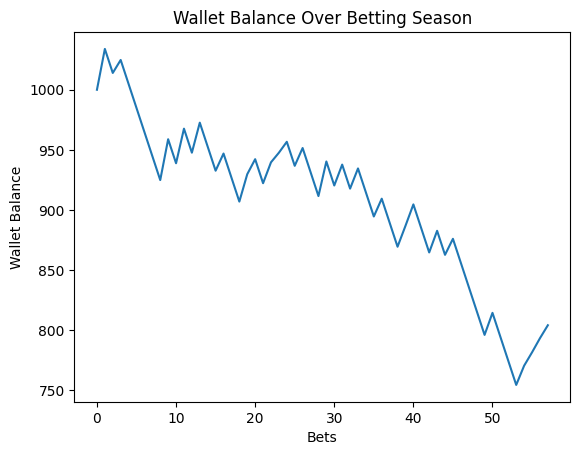

In [249]:
date1, date2 = int(str(test_year)+'0101'), int(str(test_year+1)+'0101')
subset_df = merged_player_dataframe[(merged_player_dataframe['date'] >= date1) & (merged_player_dataframe['date'] <= date2)]
player_list = subset_df['lineup'].to_frame()

results, bets, skipped = predict_game_outcome(player_list, train_player_data, model, augment=False, scaler=10, base_bet=20)

final_bets = generate_bets(results, bets, subset_df, skipped)

print('Number of games: ', len(subset_df))
print('Predictions: ', results)
print('Bets: ', bets)

wallet_balance, wallet_balance_history = simulate_betting_season(final_bets, merged_dataframes)
print(wallet_balance)
print(wallet_balance_history)
plt.plot(wallet_balance_history)
plt.title('Wallet Balance Over Betting Season')
plt.xlabel('Bets')
plt.ylabel('Wallet Balance')
plt.show()

In [250]:
len(merged_dataframes)

373

105

In [251]:
print(final_bets)

[(20, 'CIN', 20200724), (20, 'PHI', 20200724), (20, 'BOS', 20200724), (20, 'COL', 20200724), (20, 'BOS', 20200725), (20, 'MIA', 20200725), (20, 'TEX', 20200725), (20, 'PHI', 20200726), (20, 'BAL', 20200726), (20, 'TEX', 20200726), (20, 'TOR', 20200727), (20, 'PIT', 20200727), (20, 'PIT', 20200728), (20, 'TEX', 20200728), (20, 'OAK', 20200728), (20, 'TEX', 20200729), (20, 'PIT', 20200729), (20, 'MIN', 20200730), (20, 'MIN', 20200731), (20, 'CIN', 20200802), (20, 'DET', 20200802), (20, 'MIN', 20200802), (20, 'MIN', 20200803), (20, 'MIN', 20200804), (20, 'TOR', 20200804), (20, 'OAK', 20200804), (20, 'PIT', 20200805), (20, 'TEX', 20200805), (20, 'ARI', 20200805), (20, 'WAS', 20200807), (20, 'DET', 20200807), (20, 'TOR', 20200807), (20, 'OAK', 20200807), (20, 'SEA', 20200807), (20, 'PIT', 20200808), (20, 'OAK', 20200808), (20, 'ATL', 20200808), (20, 'WAS', 20200808), (20, 'CIN', 20200808), (20, 'TOR', 20200808), (20, 'WAS', 20200809), (20, 'PHI', 20200809), (20, 'ATL', 20200809), (20, 'PIT'

In [252]:
# len(final_bets)
len(train_player_data)

2465

# Misc

In [253]:
missing_players = check_missing_players(player_list, train_player_data)
print('Missing players:', missing_players)
len(missing_players)

Missing players: ['l', 'i', 'n', 'e', 'u', 'p']


6

In [254]:
print(skipped)
# for index in skipped:missing_players_per_game = []


[4, 8, 9, 11, 13, 17, 18, 22, 26, 28, 29, 30, 31, 33, 36, 37, 39, 41, 44, 45, 47, 48, 51, 52, 53, 54, 55, 56, 57, 61, 70, 73, 75, 78, 79, 80, 84, 85, 88, 89, 91, 95, 96, 99, 100, 101, 102, 104, 106, 110, 111, 113, 115, 116, 118, 119, 120, 122, 124, 126, 128, 130, 133, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 161, 162, 163, 164, 165, 166, 167, 169, 170, 172, 174, 175, 176, 177, 178, 179, 181, 182, 184, 186, 187, 188, 190, 192, 194, 195, 196, 197, 199, 200, 201, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 220, 222, 224, 225, 226, 227, 228, 229, 232, 233, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253, 254, 255, 257, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 3

In [255]:
len(pd.DataFrame(train_player_data.keys()))
len(player_list)

373

In [256]:
# extra_players_per_game = []
# for game in player_list_df.iloc[:, 0]:
#     # Flatten the list of players for the current game
#     game_players_flat = [player for sublist in game for player in sublist]
#     # Convert the list into a set to remove duplicates
#     game_player_set = set(game_players_flat)
#     extra_players = train_player_set - game_player_set
#     extra_players_per_game.append(extra_players)

# print(extra_players_per_game)

In [260]:
def check_missing_players_per_game(player_list, player_data):
    missing_players_per_game = []
    for game in player_list:
        missing_players = []
        for team in game:
            for player in team:
                if player.lower() not in player_data:
                    missing_players.append(player)
        missing_players_per_game.append(missing_players)
    return missing_players_per_game

missing_players_per_game = check_missing_players_per_game(player_list['lineup'], train_player_data) #Check if there are any wrong player names between the two datasets
# missing_players_per_game = check_missing_players_per_game(player_list['lineup'], train_player_data) #Check if there are any players  
for i, missing_players in enumerate(missing_players_per_game):
    print(f'Missing players for game {i+1}:', missing_players)

Missing players for game 1: []
Missing players for game 2: []
Missing players for game 3: []
Missing players for game 4: []
Missing players for game 5: ['Evan White', 'Jose Marmolejos']
Missing players for game 6: []
Missing players for game 7: []
Missing players for game 8: []
Missing players for game 9: ['Evan White']
Missing players for game 10: ['Shogo Akiyama']
Missing players for game 11: []
Missing players for game 12: ['Shogo Akiyama']
Missing players for game 13: []
Missing players for game 14: ['Evan White', 'Jose Marmolejos', 'Taylor Jones']
Missing players for game 15: []
Missing players for game 16: []
Missing players for game 17: []
Missing players for game 18: ['Evan White', 'Jose Marmolejos']
Missing players for game 19: ['Santiago Espinal']
Missing players for game 20: []
Missing players for game 21: []
Missing players for game 22: []
Missing players for game 23: ['Vimael Machin']
Missing players for game 24: []
Missing players for game 25: []
Missing players for game 

In [261]:
def remove_empty_and_duplicate_games(missing_players_per_game):
    filtered_games = []
    for game in missing_players_per_game:
        if game and game not in filtered_games:
            filtered_games.append(game)
    return filtered_games

filtered_games = remove_empty_and_duplicate_games(missing_players_per_game)
for i, missing_players in enumerate(filtered_games):
    print(f'Missing players for game {i+1}:', missing_players)



Missing players for game 1: ['Evan White', 'Jose Marmolejos']
Missing players for game 2: ['Evan White']
Missing players for game 3: ['Shogo Akiyama']
Missing players for game 4: ['Evan White', 'Jose Marmolejos', 'Taylor Jones']
Missing players for game 5: ['Santiago Espinal']
Missing players for game 6: ['Vimael Machin']
Missing players for game 7: ['Daniel Johnson']
Missing players for game 8: ['Shogo Akiyama', 'Rony Garcia']
Missing players for game 9: ['Daniel Johnson', 'Shogo Akiyama']
Missing players for game 10: ['Cristian Javier', 'Daulton Varsho']
Missing players for game 11: ['Monte Harrison']
Missing players for game 12: ['Tejay Antone', 'Shogo Akiyama']
Missing players for game 13: ['Hyun-Jin Ryu']
Missing players for game 14: ['Eddy Alvarez', 'Monte Harrison']
Missing players for game 15: ['Joshua Allen Smith', 'Eddy Alvarez']
Missing players for game 16: ['JT Brubaker']
Missing players for game 17: ['Anderson Tejeda']
Missing players for game 18: ['Nate Pearson']
Missing 

In [259]:
# train_dataset = vector_dataset(X_train_resampled, y_train_resampled)
# instantiate the random undersampler
#rus = RandomUnderSampler(random_state=42)

# instantiate SMOTE
#smote = SMOTE(random_state=42)

# resample X_train and y_train using undersampling
#X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# resample X_train and y_train using SMOTE
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print the new class distribution after undersampling
#print('Resampled dataset shape after undersampling %s' % len(X_train_resampled))

# print the new class distribution after SMOTE
#print('Resampled dataset shape after SMOTE %s' % len(X_train_smote))